# My Optimizers

В этом домашнем задании вам предстоит реализовать своими руками оптимизаторы.

Часть кода оптимизаторов уже реализована - есть подсказки в `__init__` и определен метод `step`. По сути, вам остается только заполнить недостающие части, например, по алгоритму из документации pytorch: [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

PS. Кода там совсем немного. В эталонном решении 2 класса оптимизаторов поместились на 60 строчек. Основное -- это разобраться в формулах и перенести их в код.


#### 🤔 Что если тесты не проходят?

Скорее всего, у вас где-то ошибка. Тк торчовые реаоизации оптимизаторов точно работают корректно.

Для дебага рекомендую добавить принтов, залогировать значения лосса, градиентов.
Перепроверить по шагам каждую формулу из доки торча отдельно.

Возможно добавить дебаг в код тестов - изучите их код. В тестах проверяется, что значения параметров модели оптимизированной вашим и торчовым оптимизатором совпадает после нескольких шагов оптимизации для рандомных входных данных.

Если есть подозрение, что в тестах есть ошибка, загрузите ноутбук на колаб, сделайте ссылку, чтобы поделиться ноутбуком и скиньте мне с описанием, где ошибка, почему и возможно, вы можете сразу предложить исправление этой ошибки?)

Или на самом деле, можете сразу присылать пулл-реквест в [репозиторий, где хранятся тесты](https://github.com/fintech-dl-hse/checkhw/tree/main/tests/optimization))



#### ❗ Hint

**Torch/Numpy**
В `pytorch` очень много методов называются аналогично numpy. В том числе есть
`torch.rand_like`, `torch.zeros_like`, `torch.ones_like` методы. Возможно, некоторые из этих методов могут вам потребоваться при решении текущей домашки.

**Важно!** Обратите, пожалуйста, внимание, что во время шага оптимизации нельзя делать шаг обновления на самих тензорах. Надо работать напрямую с данными тензора (см первый сем)

```python
for param in model.parameters():
    param.data = param.data - learning_rate * param.grad
```



#### 🙈 Доп задание



В конце ноутбука есть опциональная часть задания. Эта часть не влияет на оценку, но желательна к исполнению, чтобы закрепить материал. Приступайте к опциональной части дз только после того, как убедились, что все тесты проходят и вы получили баллы за обязательную часть дз.





## Обязательная часть ДЗ:

In [9]:
import torch
import torch.nn as nn
# Другие импорты нельзя добавлять. Убирать тоже нельзя. Эта ячейка будет
# копироваться в отдельный файл во время проверки домашки.

class MySGD():
    # see formulas in pytorch docs
    # https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    #
    # В официальной реализации у оптимизатор поддерживает большее количество параметров
    # Но нужно поддержать только те, которые прописаны в заготовке ДЗ.
    def __init__(self, parameteres_generator, lr=0.001):
        super().__init__()

        self.model_params = list(parameteres_generator)
        self.learning_rate = lr

        return

    def step(self):
        """
        В этом методе надо реализовать шаг оптмизации
        """
        for param in self.model_params:
          if param.grad is not None:
            param.data -= self.learning_rate * param.grad

        # your code here

        return

class MyAdam():
    # see formulas in pytorch docs
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    #
    # В официальной реализации у оптимизатор поддерживает большее количество параметров
    # Но нужно поддержать только те, которые прописаны в заготовке ДЗ.
    def __init__(self, parameteres_generator, lr=0.001, betas=(0.9, 0.999), eps=1e-08):
        super().__init__()

        self.model_params = list(parameteres_generator)
        self.learning_rate = lr

        self.beta_moment_1 = betas[0]
        self.beta_moment_2 = betas[1]
        self.eps = eps

        self.step_counter = 0

        # В parameters_moment_* нужно хранить значения первого и второго момента
        # градиента для всех параметров
        # То есть каждому элементу из self.model_params будет
        # на таком же индексе списка соответствовать тензор такой же разменрости
        # что и сами параметры тензор со значениями моментов градиентов для всех параметров
        self.parameters_moment_1 = [torch.zeros_like(param.data) for param in self.model_params]
        self.parameters_moment_2 = [torch.zeros_like(param.data) for param in self.model_params]

        return

    def step(self):
        """
        В этом методе надо реализовать шаг оптимизации
        """
        self.step_counter += 1

        for i, param in enumerate(self.model_params):
            if param.grad is not None:
                grad = param.grad.data
                self.parameters_moment_1[i] = (self.beta_moment_1 * self.parameters_moment_1[i] + (1 - self.beta_moment_1) * grad)
                self.parameters_moment_2[i] = (self.beta_moment_2 * self.parameters_moment_2[i] + (1 - self.beta_moment_2) * (grad ** 2))
                # коррекция смещения
                m_hat = self.parameters_moment_1[i] / (1 - self.beta_moment_1 ** self.step_counter)
                v_hat = self.parameters_moment_2[i] / (1 - self.beta_moment_2 ** self.step_counter)
                # Обновление параметров
                param.data -= self.learning_rate * m_hat / (torch.sqrt(v_hat) + self.eps)

        # your code here

        return

#### Tests

In [10]:
from tqdm.auto import tqdm
from torch.optim import SGD, Adam
import copy


# initialize a model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(784, 2048),
            nn.ReLU(),
            nn.Linear(2048, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        return

    def forward(self, x_coordinates):
        # x_coordinates ~ [ batch_size, 2 ]
        scores = self.sequential(x_coordinates)   # [ batch_size, 10 ]
        return scores

def _optimizer_step(model, model_state, optimizer_class, optimizer_params, model_inputs_batches, target_labels_batches, criterion):
    model.load_state_dict(model_state)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    for model_inputs, target_labels in zip(model_inputs_batches, target_labels_batches):
        model.zero_grad()

        prediction = model.forward(model_inputs)
        loss = criterion(prediction, target_labels)
        # print("loss", loss.item())
        loss.backward()
        optimizer.step()

        # print("list(model.parameters())", list(model.parameters()))

    return copy.deepcopy(list(model.parameters()))


def _test_my_optimizer(torch_optimizer, my_optimizer, optimizer_params,
                       model='linear',
                       batch_size = 3, num_batches = 10,
                       name=None,
                       ):

    if model == 'linear':
        model = nn.Linear(784, 10)
    else:
        model = MLP()

    model_state = copy.deepcopy(model.state_dict())

    criterion = nn.CrossEntropyLoss()

    model_inputs =  [torch.rand([batch_size, 784]) for _ in range(num_batches)]
    target_labels = [torch.randint(0, 10, [batch_size]) for _ in range(num_batches)]

    torch_updated_params = _optimizer_step(model, model_state, torch_optimizer, optimizer_params, model_inputs, target_labels, criterion)
    my_updated_params    = _optimizer_step(model, model_state, my_optimizer,    optimizer_params, model_inputs, target_labels, criterion)

    for torch_updated_param, my_updated_param in tqdm(zip(torch_updated_params, my_updated_params), total=len(torch_updated_params), desc=name):
        # print(torch_updated_param)
        # print(my_updated_param)
        assert torch.allclose(torch_updated_param, my_updated_param, rtol=0.5, atol=1e-3), 'updated parameters are not equal'

def test_my_sgd():
    optimizer_params = {
        "lr": 0.01
    }
    torch_optimizer = SGD
    my_optimizer = MySGD

    _test_my_optimizer(torch_optimizer, my_optimizer, optimizer_params, name="Test SGD Linear")
    _test_my_optimizer(torch_optimizer, my_optimizer, optimizer_params, model='mlp', name="Test SGD MLP")


def test_my_adam():
    optimizer_params = {
        "lr": 0.01
    }
    torch_optimizer = Adam
    my_optimizer = MyAdam

    _test_my_optimizer(torch_optimizer, my_optimizer, optimizer_params, name="Test Adam Linear")
    _test_my_optimizer(torch_optimizer, my_optimizer, optimizer_params, model='mlp', name="Test Adam MLP")


test_my_sgd()
test_my_adam()

print("Tests are OK!")

Test SGD Linear:   0%|          | 0/2 [00:00<?, ?it/s]

Test SGD MLP:   0%|          | 0/6 [00:00<?, ?it/s]

Test Adam Linear:   0%|          | 0/2 [00:00<?, ?it/s]

Test Adam MLP:   0%|          | 0/6 [00:00<?, ?it/s]

Tests are OK!


# Свой train loop со своим оптимизатором

Если тесты проходят, можете обучить модель с помощью своего оптимизатора, например на задаче `FashionMNIST`.  Сравните свою реализацию с реализацией из `pytorch`.

**Важно** Эта часть ДЗ желательна, чтобы закрепить знания. Но не обязательно - проверяться не будет.

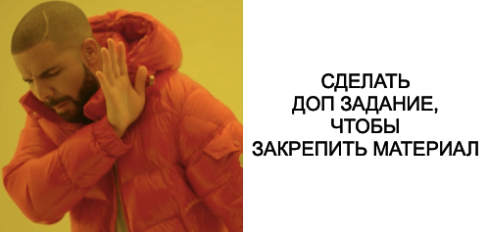

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST

In [7]:
class VectorSet():
    def __init__(self, train=True):
        self.data = FashionMNIST("./fashion_mnist", train=train, download=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample, label = self.data[item]
        sample = np.array(sample, dtype=np.float32).reshape(-1) / 255
        return dict(
            sample=sample,
            label=label,
        )

vs = VectorSet()

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]


Extracting ./fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]


Extracting ./fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.92MB/s]


Extracting ./fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.7MB/s]

Extracting ./fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



In [ ]:
# def train_loop():
# class MyTrainer
